In [2]:
import pandas as pd

#df = pd.read_csv('../data/museum_data_mean_target_encoding.csv')
df_train = pd.read_csv("/content/drive/MyDrive/data/museum_data_mean_target_encoding_train.csv")
df_train.drop(['Unnamed: 0', 'Object Begin Date'], axis=1, inplace=True)

df_test = pd.read_csv("/content/drive/MyDrive/data/museum_data_mean_target_encoding_test.csv")
df_test.drop(['Unnamed: 0', 'Object Begin Date'], axis=1, inplace=True)
df_train.head()

,Historical Period,height,diam,width,depth,num_period,medium_num,classif_num,culture_num
0,Antiquity,7.1,-1.0,10.8,-1.0,4.0,3.046062,2.533376,2.136866
1,Antiquity,-1.0,3.7,-1.0,-1.0,4.0,3.046062,3.998735,4.000000
2,Antiquity,2.9,-1.0,9.2,-1.0,4.0,3.875496,3.993417,3.905965
3,Antiquity,2.7,-1.0,2.2,-1.0,4.0,3.046062,2.533376,3.301802
4,Antiquity,-1.0,-1.0,-1.0,-1.0,4.0,3.119048,2.533376,3.841270


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df_train.iloc[20000,:]

Historical Period    Contemporary Era
height                          241.9
diam                             -1.0
width                           117.5
depth                            -1.0
num_period                        1.0
medium_num                   1.728041
classif_num                  2.153191
culture_num                  2.136866
Name: 20000, dtype: object

### Preprocessing

#### Get X and y

In [5]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

periods_train = np.array(df_train["Historical Period"]).reshape(-1, 1)

ohe = OneHotEncoder(sparse=False)
ohe.fit(periods_train)
y_ohe_train = ohe.transform(periods_train)

periods_test = np.array(df_test["Historical Period"]).reshape(-1, 1)
y_ohe_test = ohe.transform(periods_test)
y_ohe_train

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [43]:
ohe.get_feature_names_out()

array(['x0_Antiquity', 'x0_Contemporary Era', 'x0_Middle Ages',
       'x0_Modern Times'], dtype=object)

In [45]:
#map_period = {"Contemporary Era":1., "Modern Times": 2., "Middle Ages":3., "Antiquity":4.}
map_period = {"Antiquity":1., "Contemporary Era": 2., "Middle Ages":3., "Modern Times":4.}

In [6]:
# key: name of the class; item: index of the column in y
dico_period_ohe = {"Modern Times":3, "Contemporary Era":1, "Antiquity":0, "Middle Ages":2}

In [7]:
import numpy as np
y_train = np.array(df_train["num_period"])
y_train

array([4., 4., 4., ..., 2., 2., 2.])

In [8]:
X_train = np.array(df_train.drop(columns=["Historical Period", "num_period"]))
X_train.shape

(40180, 7)

In [9]:
y_test = np.array(df_test["num_period"])
X_test = np.array(df_test.drop(columns=["Historical Period", "num_period"]))

#### Rescaling the features

medium_num, culture_num and classif_num are bounded between 1 and 4 by construction (fine).


Let's transform the features related to dimensions: height, width, depth and diam. It doesn't really make sense (from a physical point of view) to normalize them to zero mean and unit variance. Instead, let's rescale them so that they are between 0 and 1:

In [10]:
X_train[0,:]

array([ 7.1       , -1.        , 10.8       , -1.        ,  3.04606152,
        2.53337623,  2.13686557])

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train[:,:4])
dims_train_minmax = scaler.transform(X_train[:,:4])

In [12]:
# check
print(np.min(dims_train_minmax, axis=0), np.max(dims_train_minmax, axis=0))

[0. 0. 0. 0.] [1. 1. 1. 1.]


In [13]:
X_train[:,:4] = dims_train_minmax
print(X_train[0,:])

[0.00339836 0.         0.00640886 0.         3.04606152 2.53337623
 2.13686557]


In [14]:
# apply the same transformation on testing set
dims_test_minmax = scaler.transform(X_test[:,:4])
X_test[:,:4] = dims_test_minmax
X_test[0,:]

array([0.        , 0.00655793, 0.        , 0.        , 2.93310463,
       3.05988515, 2.96666667])

### Deep learning architectures

MLP

In [17]:
#@title Imports libraries
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from glob import glob
import os
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [28]:
num_features = X_train.shape[1]
num_classes = 4

mlp_baseline = Sequential()
mlp_baseline.add(Dense(10, activation='relu'))
mlp_baseline.add(Dense(num_classes, activation = 'softmax'))

In [29]:
mlp_baseline.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])
mlp_baseline.fit(X_train, y_ohe_train, epochs=5)

Epoch 1/5
1256/1256 [==============================] - 2s 2ms/step - loss: 1.1561 - accuracy: 0.4700
Epoch 2/5
1256/1256 [==============================] - 2s 2ms/step - loss: 0.8495 - accuracy: 0.6341
Epoch 3/5
1256/1256 [==============================] - 2s 2ms/step - loss: 0.7674 - accuracy: 0.6777
Epoch 4/5
1256/1256 [==============================] - 2s 2ms/step - loss: 0.7306 - accuracy: 0.6972
Epoch 5/5
1256/1256 [==============================] - 2s 2ms/step - loss: 0.7097 - accuracy: 0.7040


In [56]:
mlp_baseline.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 10)                80        
                                                                 
 dense_9 (Dense)             (None, 4)                 44        
                                                                 
Total params: 124
Trainable params: 124
Non-trainable params: 0
_________________________________________________________________


In [49]:
def plot_confusion_matrix(model, X_test, y_test, model_name=""):
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns

    #preds = model.predict(X_test)
    preds = np.argmax(model.predict(X_test), axis=1) # adapt to softmax
    conf_mat = confusion_matrix(y_test, preds)
    plt.figure(figsize=(8,8))
    sns.heatmap(conf_mat, cmap="Blues",
    annot=True,
    )
    plt.title("Confusion matrix of {}".format(model_name))
    plt.xlabel("Predicted class")
    plt.ylabel("True class")
    plt.show()

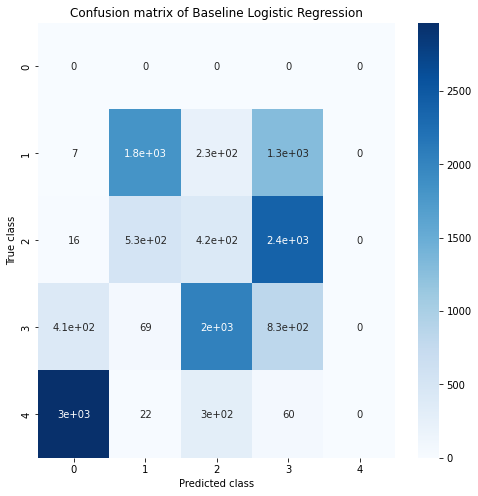

In [50]:
plot_confusion_matrix(mlp_baseline, X_test, y_test, model_name="Baseline Logistic Regression")

In [54]:
#from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

accuracy_score(y_test, np.argmax(mlp_baseline.predict(X_test), axis=1))

0.22954613317408182